In [7]:
import os, importlib, sys
from collections import defaultdict
from stream.client import draw_minimap, frames_to_map
import numpy as np
from PIL import Image
from helpers import shrink_image, pad_to_square_multiple

In [ ]:
"""
manually captured frames of coast map in 4k
- the frames are grouped by key, where each key represents a separate instance of the layout
- first frame of a group is always centered at map entrance, we track origin position based on this first frame
- the frame groups are further grouped by layout ID, which was assigned by human inspection as ground truth

current approach to train a vision transformer:

1. for each set of N frames, assemble N minimaps:
 {frame 0}, {frame 0 + frame 1}, ..., {frame 0 + .. + frame N}
 where {frame + frame} represents assembling a composite minimap from minimap slices in these frames
 
2. then extract minimap feature masks, crop to minimize surrounding blank space

3. each minimap patch set is an input, output is softmax probabilities for N classes, where N is the number of unique layouts
"""

In [45]:
### one-time use code for organizing manually-captured data on disk
import shutil

# in future, store new training data as:
"""
data/train/layout_id/instance_id/frame_id.png
where layout_id is assigned by the human labeler
instance_id is autoincremented from 0 to positive integers with each new instance data
frame_id is autoincremented non-negative integer, 
  smallest frame_id is the first frame at map origin, collected in chronological order
"""
for layout in os.listdir("data/train_old"):
    data_dir = os.path.join("data/train_old", layout)
    files = set(os.listdir(data_dir))
    key_map = {}
    for file in files:
        if file.endswith(".png"):
            key = file.split("screenshot-")[0]
            if key not in key_map:
                if len(key_map.values()) == 0:
                    key_map[key] = 0
                else:
                    key_map[key] = max(key_map.values()) + 1
            dest_layout_dir = f"data/train/{layout}"
            if str(key_map[key]) not in os.listdir(dest_layout_dir):
                os.mkdir(f"{dest_layout_dir}/{key_map[key]}")
            full_path = os.path.join(data_dir, file)
            number = int(file.split("screenshot-")[1][:-4])
            dest = f"{dest_layout_dir}/{key_map[key]}/{number}.png"
            shutil.copy(full_path, dest)

In [ ]:
"""
Generate minimap patches:
- for every frame, construct minimap up to and including that frame
- convert minimap to nonempty patches, track coords of each patch rel. to origin
- save data as .npz with 'patches' and 'coords' arrays
- during training, we will use 'coords' for position embeddings to be added to patches
- every "frame_id.png" file will have corresponding "frame_id.npz" file with patches/coords
"""

In [143]:
importlib.reload(sys.modules['stream.client'])

<module 'stream.client' from '/home/andrew/poemap/stream/client.py'>

In [144]:
from stream.client import get_moves

In [11]:
a = set((1,2,3))
a

{1, 2, 3}

In [12]:
a.pop()
a

{2, 3}

In [16]:
if set((1,2,3)):
    print("a")

a


In [230]:
from typing import DefaultDict

def find_unprocessed_frames(data_dir: str) -> DefaultDict[str, set]:
    not_done = defaultdict(set)
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            prefix, ext = os.path.splitext(file)
            if ext == ".png" and f"{prefix}.npz" not in files:
                #not_done[root].add(os.path.join(root, file))
                not_done[root].add(file)
    return not_done
    
get_frame_id = lambda x: int(os.path.splitext(x)[0])

# extract middle of 4k frame
# player icon is at 1920, 1060, in 4k
def crop_frame(frame: np.ndarray, box_radius: int):
    return frame[1060-box_radius: 1060+box_radius, 1920-box_radius: 1920+box_radius, :]

def prepare_training_data(data_dir):
    todo = find_unprocessed_frames(data_dir)
    for instance in todo:
        # don't process unneeded frames past max_frame_id
        max_frame_id = max(get_frame_id(f) for f in todo[instance])
        frames = [(get_frame_id(f), f) for f in os.listdir(instance)]
        # both frames and moves will be in chronological order due to sorting
        frames = sorted([(fid, f) for fid, f in frames if fid <= max_frame_id])
        frames = [(fid, crop_frame(np.array(Image.open(os.path.join(instance, f))), 600)) for fid, f in frames]
        # calculating moves is expensive, so we do it upfront once for all frames, then slice thereafter
        moves = get_moves([f for fid, f in frames])
        for target_frame in todo[instance]:
            tf_id = get_frame_id(target_frame)
            tf_idx = next((i for i, tpl in enumerate(frames) if tpl[0]==tf_id), -1)
            frames_subset = np.array([f for fid, f in frames][0:tf_idx + 1])
            minimap, origin = draw_minimap(frames_subset, moves[0:tf_idx + 1])

            # shrink image, recalculate origin
            dims = minimap.shape[0:2]
            max_dim_idx = dims.index(max(dims))
            new_size = dims[max_dim_idx] // 2
            origin = tuple(int(x * new_size / max(dims)) for x in origin)
            minimap = shrink_image(minimap, new_size)
            # pad image, use mask to track origin position
            mask = np.zeros((*minimap.shape[0:2], 1))
            mask[origin] = 1
            minimap = np.concatenate([minimap, mask], axis=-1)
            minimap = pad_to_square_multiple(minimap, 32)
            origin = np.where(minimap[..., 3] == 1)
            origin = tuple(int(x[0]) for x in origin)
            minimap = minimap[:,:,0:3].astype(np.uint8)
            yield minimap, origin
            #break
        break

In [231]:
asdf = prepare_training_data("data/train")

In [237]:
m, o = next(asdf)

In [ ]:
# Run inference to extract mask of minimap features

In [ ]:
from models import AttentionUNet

In [ ]:
model_name = "AttentionUNet_4"
model = AttentionUNet(model_name)
model.load()

In [ ]:
pred = model.batch_inference(padded, chunk_size=32)

In [ ]:
display(Image.fromarray(padded))
display(Image.fromarray(pred * 255, mode="L"))

In [ ]:
pred.shape

In [ ]:
from scipy.ndimage import convolve

def crop_to_content(image):
    white_pixels = np.argwhere(image == 1)
    assert len(white_pixels) > 0
    
    y_min, x_min = white_pixels.min(axis=0)
    y_max, x_max = white_pixels.max(axis=0)
    cropped_image = image[y_min:y_max+1, x_min:x_max+1]
    return cropped_image, (y_min, x_min)

def clean_sparse_pixels(image, threshold=3, neighborhood_size=3):
    # Create a kernel for counting neighbors
    kernel = np.ones((neighborhood_size, neighborhood_size))
    kernel[neighborhood_size//2, neighborhood_size//2] = 0  # Don't count the pixel itself
    # Count white neighbors for each pixel
    neighbor_count = convolve(image.astype(int), kernel, mode='constant')
    # Create a mask of pixels to keep (either black or with enough white neighbors)
    mask = (image == 0) | (neighbor_count >= threshold)
    # Apply the mask to the original image
    cleaned_image = image * mask
    
    return cleaned_image

In [ ]:
clean = clean_sparse_pixels(pred, threshold=20, neighborhood_size=40)
clean, offsets = crop_to_content(clean)
display(Image.fromarray(padded))
display(Image.fromarray(clean * 255, mode="L"))

In [ ]:
clean_origin = tuple(int(val - offset) for val, offset in zip(shrunk_origin, offsets))

In [ ]:
x, y = clean_origin
Image.fromarray(clean[x-50:x+50, y-50:y+50] * 255, mode="L")

In [ ]:
clean.shape

In [ ]:
clean_origin

In [ ]:
# Chunk the map into square patches, label each patch with y,x positions relative to origin
# We will use the y,x positions for token position embeddings
def get_patches(array, origin, ps=32):
    assert len(array.shape) == 2
    Y, X = array.shape
    # calc num patches in each direction from origin
    y, x = origin
    up, down = y//ps, (Y-y)//ps
    left, right = x//ps, (X-x)//ps
    patches = array[y-ps*up : y+ps*down, x-ps*left : x+ps*right]

    # calc patch y,x dims for each pixel, relative to origin patch
    indices = np.indices(patches.shape).transpose(1,2,0)
    indices = indices // ps - np.array([up, left])
    patches = patches.reshape(*patches.shape, 1)
    patches = np.concatenate([patches, indices], axis=-1)

    return patches

In [ ]:
patches = get_patches(clean, clean_origin)

In [ ]:
Image.fromarray(patches[:,:,0].astype(np.uint8) * 255, mode="L")

In [ ]:
# Remove completely black patches
def get_tokens(patches):
    Y,X = patches.shape[0:2]
    y_patches, x_patches = Y // 32, X // 32
    tokens = []
    for i in range(y_patches):
        for j in range(x_patches):
            patch = patches[i*32 : (i+1)*32, j*32 : (j+1)*32]
            if np.any(patch[:,:,0] > 0):
                tokens.append(patch)
    return np.array(tokens)

In [ ]:
tokens = get_tokens(patches)

In [ ]:
tokens.shape

In [ ]:
for p in tokens:
    #display(Image.fromarray(p[:,:,0].astype(np.uint8) * 255, mode="L"))
    pass

In [248]:
x = np.load("data/train/4/0/2.npz")['data']
x.shape

(7, 32, 32, 3)

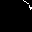

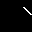

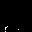

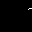

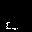

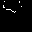

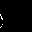

In [251]:
for p in range(x.shape[0]):
    display(Image.fromarray(x[p,:,:,0].astype(np.uint8) * 255, mode="L"))

In [256]:
x = np.load("data/train/4/0/2.npz")['data']
x.shape

(15, 32, 32, 3)

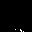

-11
8


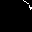

-10
8


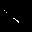

-10
9


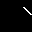

-8
8


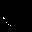

-8
9


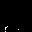

-4
2


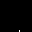

-3
-1


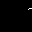

-3
0


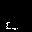

-3
1


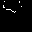

-3
2


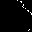

-2
-1


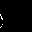

-2
0


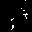

-1
-1


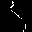

0
-1


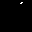

1
-1


In [282]:
for p in range(x.shape[0]):
    display(Image.fromarray(x[p,:,:,0].astype(np.uint8) * 255, mode="L"))
    print(x[p,0,0,1])
    print(x[p,0,0,2])

In [ ]:
"""
Training:
- Group all "frame_id.npz" filenames by class (layout_id)
- Sample enough npz files to fill GPU memory while maintaining class balance,
  accumulate gradients if needed
"""

In [ ]:
for module in ('models.vit', 'models'):
    client_module = sys.modules[module]
    importlib.reload(client_module)
from models import ViT

In [ ]:
model = ViT(9, max_tokens=128, layers=3, embed_dim=256, num_heads=4)
#model_name = "AttentionUNet_1"
#model = ViT(model_name)
#model.train()

In [ ]:
tokens.shape

In [ ]:
y = model([tokens])

In [ ]:
y = y.numpy().ravel()

In [ ]:
y.shape

In [ ]:
y.argmax()